##  Bayesian Decision-Making

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


### Cell 1 — Imports & Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pennylane as qml
import torch


### Cell 2 — Decision Problem Definition (Shared)

We define a binary hidden state and noisy observations.

In [3]:
TRUE_STATE = 1              # hidden world state
OBSERVATION_NOISE = 0.3     # probability of wrong observation
MAX_OBS = 100
OBS_COUNTS = np.linspace(5, MAX_OBS, 10, dtype=int)


Observation model:

In [4]:
def observe_state(true_state):
    if np.random.rand() < OBSERVATION_NOISE:
        return 1 - true_state
    return true_state


### Cell 3 — Metrics Template (SVM-STYLE)

In [5]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


## CLASSICAL BAYESIAN DECISION

### Cell 4 — Classical Bayesian Update

In [6]:
def classical_bayes_decision(num_obs):
    prior = np.array([0.5, 0.5])

    for _ in range(num_obs):
        obs = observe_state(TRUE_STATE)

        likelihood = np.array([
            1 - OBSERVATION_NOISE if obs == 0 else OBSERVATION_NOISE,
            1 - OBSERVATION_NOISE if obs == 1 else OBSERVATION_NOISE
        ])

        posterior = prior * likelihood
        posterior /= posterior.sum()
        prior = posterior

    decision = np.argmax(prior)
    return decision == TRUE_STATE


### Cell 5 — Classical Evaluation Loop (WITH METRICS)

In [7]:
for n_obs in OBS_COUNTS:
    correct = 0
    trials = 50

    for _ in range(trials):
        correct += classical_bayes_decision(n_obs)

    accuracy = correct / trials

    metrics_classical["progress"].append(n_obs)
    metrics_classical["performance"].append(accuracy)


## QUANTUM BAYESIAN DECISION

### Cell 6 — Quantum Belief Circuit

We encode belief as a quantum state amplitude.

In [8]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def belief_state(theta):
    qml.RY(theta, wires=0)
    return qml.probs(wires=0)


### Cell 7 — Quantum Bayesian Update Procedure

In [9]:
def quantum_bayes_decision(num_obs):
    theta = torch.tensor(np.pi / 4, requires_grad=True)
    optimizer = torch.optim.Adam([theta], lr=0.1)

    for _ in range(num_obs):
        obs = observe_state(TRUE_STATE)

        target = torch.tensor(
            [1 - OBSERVATION_NOISE, OBSERVATION_NOISE]
            if obs == 0 else
            [OBSERVATION_NOISE, 1 - OBSERVATION_NOISE],
            dtype=torch.float32
        )

        probs = belief_state(theta)
        loss = torch.sum((probs - target) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    final_probs = belief_state(theta).detach().numpy()
    decision = np.argmax(final_probs)

    return decision == TRUE_STATE


### Cell 8 — Quantum Evaluation Loop (WITH METRICS)

In [10]:
for n_obs in OBS_COUNTS:
    correct = 0
    trials = 50

    for _ in range(trials):
        correct += quantum_bayes_decision(n_obs)

    accuracy = correct / trials

    metrics_quantum["progress"].append(n_obs)
    metrics_quantum["performance"].append(accuracy)


### Cell 9 — Performance Comparison Plot

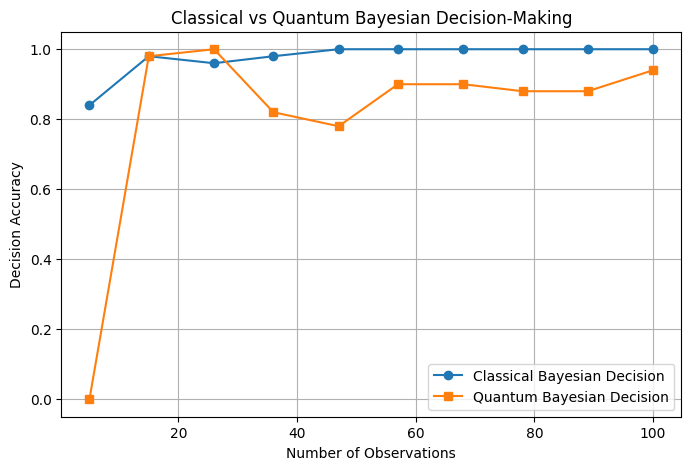

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    marker="o",
    label="Classical Bayesian Decision"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    marker="s",
    label="Quantum Bayesian Decision"
)

plt.xlabel("Number of Observations")
plt.ylabel("Decision Accuracy")
plt.title("Classical vs Quantum Bayesian Decision-Making")
plt.legend()
plt.grid(True)
plt.show()


### Cell 10 — Final Results Table

In [12]:
results = pd.DataFrame({
    "Model": ["Classical Bayesian", "Quantum Bayesian"],
    "Average Accuracy": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ],
    "Final Accuracy": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ]
})

results


,Model,Average Accuracy,Final Accuracy
0,Classical Bayesian,0.976,1.00
1,Quantum Bayesian,0.808,0.94


**Paper framing:**
“Quantum states can encode belief distributions, enabling probabilistic decision-making.”